# Benchmarking spike sorters


To benchmark the spike sorting algorithms, one of the easiest option is to design artifical dataset, in order to know exactly what is created, and to have a proper "ground truth" to compare with. 

To do so, MEArec is a python package that can help you to generate such artificial datasets. Basically, given some templates and a probe layout, the software will generate traces that can later be used for benchmarking the sorting algorithms. In this notebook, we'll try to get a quick overview of the features allowed by MEArec such that you can test the limits of various spike sorters. 

The comparison between different sorters can be tedious, since every one of them has a different file format. However, spikeinterface can act as a universal wrapper allowing you to launch and read the results of the sorters. Moreover, spikeinterface comes with numerous analysis functions that will allow you to quickly assess the quality of a spike sorting, and compute quality metrics with respect to the Ground Truth that have been generated


The only file needed here will be "templates_Neuronexus-32_100.h5", that we will use to generate the artificial recordings.

In [1]:
%matplotlib 

In [3]:
from pathlib import Path
import os

import numpy as np
import matplotlib.pyplot as plt

import MEArec as mr

import neo
import quantities as pq

import spikeinterface.full as si

## Step 1 : generation of the recordings

Here is a small code that will generate a recording given an already generated "templates" file.



In [4]:
basedir = Path('.')
template_filename = basedir / 'templates_Neuronexus-32_100.h5'


duration = 30*60 # duration (in s) of the recording
n_cell = 10 # number of cells we want to create
probe = 'Neuronexus-32' # probe layout
recording_filename = basedir / f'recordings_collision_{n_cell}cells_{probe}_{duration:0.0f}s.h5'

In [5]:
# some parameters should be provided
fs = 30000. # sampling rate (in Hz)
spikerate = 5. # firing rate of the cells (in Hz)


First, we need to generate the spike trains that we want to inject into our traces. The easiest thing is to generate Poisson spike trains

In [6]:
# generate poisson spiketrains, for every cell in our recording
spiketimes = []
for i in range(n_cell):
    n = int(spikerate * duration)
    stimes = np.random.rand(n) * duration
    stimes = np.sort(stimes)
    spiketimes.append(stimes)

# make neo spiketrains
spiketrains = []
for i in range(n_cell):
    spiketrain = neo.SpikeTrain(spiketimes[i], units='s', t_start=0*pq.s, t_stop=duration*pq.s)
    spiketrain.annotate(cell_type='E')
    spiketrains.append(spiketrain)

Now we need to use MEARec to generate an artificial recording, given our pre-generated templates and our spike trains. The amount of noise in the recording can be controlled via the parameter noise_level

In [9]:
# generate signals from spiketrain
spgen = mr.SpikeTrainGenerator(spiketrains=spiketrains)

rec_params = mr.get_default_recordings_params()
rec_params['recordings']['fs'] = fs
rec_params['recordings']['sync_rate'] = None
rec_params['recordings']['sync_jitter'] = 5
rec_params['recordings']['noise_level'] = 5
rec_params['recordings']['filter'] = False
rec_params['recordings']['chunk_duration'] = 10.
rec_params['spiketrains']['duration'] = duration
rec_params['spiketrains']['n_exc'] = n_cell
rec_params['spiketrains']['n_inh'] = 0
rec_params['templates']['n_overlap_pairs'] = None
rec_params['templates']['min_dist'] = 0

recgen = mr.gen_recordings(params=rec_params, spgen=spgen, 
            templates=template_filename, verbose=True,
            n_jobs=1, tmp_mode='memmap')



Noise Level  5
Templates selection seed:  9447
Selecting cells
Padding template edges
Elapsed pad time: 0.12082219123840332
Elapsed resample time: 0.007848978042602539
Creating time jittering
Elapsed jitter time: 0.23800206184387207
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  2596
Electrode modulaton
Adding noise
Noise seed:  8360
Elapsed time:  108.07256840800073


In [12]:
# Then we can save our recording
mr.save_recording_generator(recgen, filename=recording_filename)

## Step 2 : opening and ploting the signals and the spikes from our ground truth

In [13]:
# And use it to load the recording
rec  = si.MEArecRecordingExtractor(recording_filename)

# and the ground truth sorting
sorting_gt = si.MEArecSortingExtractor(recording_filename)


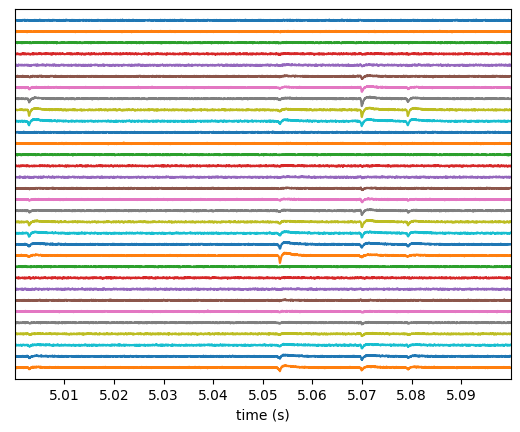

In [14]:
si.plot_timeseries(rec, time_range=(5,5.1))

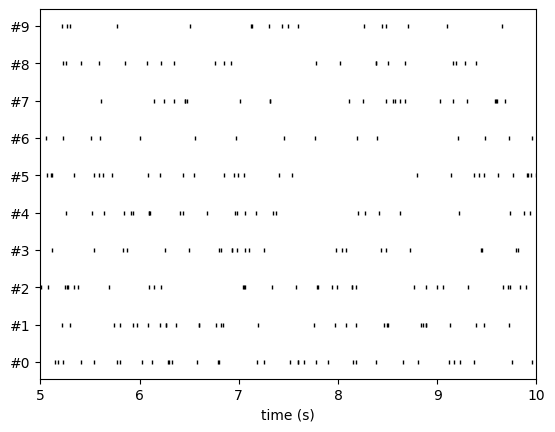

In [15]:
# We can also look at spikes
si.plot_rasters(sorting_gt, time_range=(5,10))

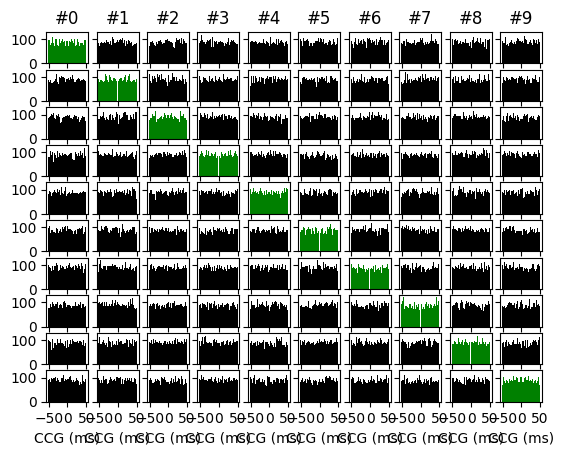

In [16]:
#Or even at thecross correlograms between the injected neurons (should be flat, because Poisson sources)
si.plot_crosscorrelograms(sorting_gt, bin_ms=2, window_ms=100, symmetrize=True)

## Step 3 : running several sorters on our recording

With spikeinterface, launching a spike sorting algorithm is easy. You simply need to do use the run_sorter command. Assuming we want to save every sorting into a specific folder, with a name dedicated to every sorter, we can simply do

In [17]:
for sorter_name in ['spykingcircus', 'tridesclous']:
    si.run_sorter(sorter_name, rec, output_folder=basedir / sorter_name)

# Note that the sorter list can includes 'kilosort', 'herdingspikes', ... See spikeinterface wrapper for more info

RUNNING SHELL SCRIPT: spykingcircus/run_spykingcircus.sh
h5py version > 2.10.0. Some extractors might not work properly. It is recommended to downgrade to version 2.10.0: 
>>> pip install h5py==2.10.0


Once a given sorter has been launched, you can load its results easily

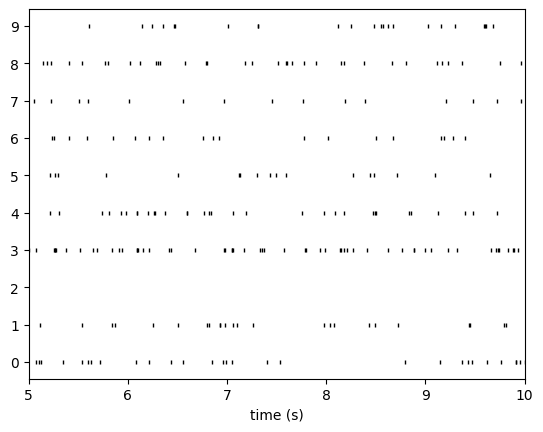

In [18]:
sorting = si.read_sorter_folder(basedir / 'spykingcircus')
# We can also look at spikes
si.plot_rasters(sorting, time_range=(5,10))

You just noticed how easy it is to run several sorters on a given recording. But what about comparisons? Now we would like to be able to quantify how good these sorters are, with respect to the ground truth units that have been created. 

## Step 4 : running comparison and ploting agreement matrix

Once we have a given spike sorting, we can always compare it to its ground-truth, via the comparison object offered by spikeinterface

In [19]:
comp = si.GroundTruthComparison(sorting, sorting_gt)

Such a comparison object can immediatly tell us how many units are found, what are the errors rates, and much more

In [20]:
comp.agreement_scores # TO view the quality score between units

,#0,#1,#2,#3,#4,#5,#6,#7,#8,#9
0,0.002180,0.001676,0.001676,0.001396,0.001844,0.991115,0.002516,0.003526,0.002292,0.001340
1,0.001895,0.001784,0.002622,0.996889,0.002119,0.001281,0.001672,0.002398,0.002231,0.002566
2,0.000109,0.001531,0.009143,0.000000,0.009032,0.005598,0.000328,0.000109,0.000000,0.000655
3,0.002373,0.002939,0.495337,0.003128,0.495589,0.000827,0.002524,0.002524,0.002713,0.002335
4,0.002345,0.946649,0.003690,0.001674,0.003578,0.001171,0.002345,0.002513,0.003971,0.004532
5,0.002465,0.002633,0.001735,0.002633,0.001735,0.001399,0.001791,0.001511,0.002240,0.988444
6,0.002299,0.002018,0.001625,0.002299,0.002636,0.002243,0.002299,0.001906,0.984899,0.001906
7,0.002359,0.002190,0.001909,0.001572,0.001853,0.002528,0.981566,0.002247,0.001010,0.001066
8,0.996889,0.002287,0.001895,0.001895,0.001840,0.002231,0.002342,0.002678,0.002454,0.002398
9,0.002622,0.002622,0.002286,0.002286,0.001616,0.003070,0.002063,0.997000,0.001951,0.001560


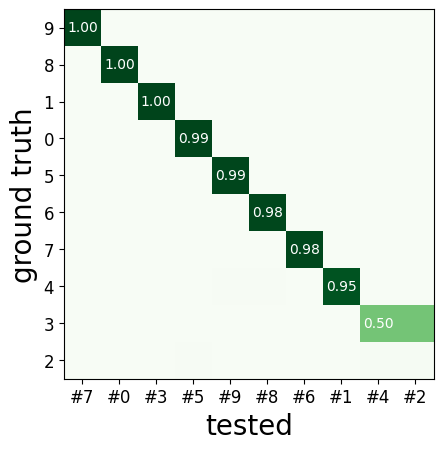

In [21]:
si.plot_agreement_matrix(comp)

## Step 5 : using the study object and plotting performances

What if we have several spike sorting algorithms, and want to quickly compare each of them, in order to get a sense of the pros and cons of every sorters? This can also be done easily in spikeinterface via the study object. The study can compare several sorters not only on a single, but on multiple recordings at once. In order to probe its potentiel, let's generate a second recording via MEAreac, for example with a larger noise level, but same spike trains

In [23]:
recording_filename_2 = basedir / f'recordings_collision_{n_cell}cells_{probe}_{duration:0.0f}s_noisy.h5'

# generate signals from spiketrain
spgen = mr.SpikeTrainGenerator(spiketrains=spiketrains)

rec_params = mr.get_default_recordings_params()
rec_params['recordings']['fs'] = fs
rec_params['recordings']['sync_rate'] = None
rec_params['recordings']['sync_jitter'] = 5
rec_params['recordings']['noise_level'] = 8
rec_params['recordings']['filter'] = False
rec_params['recordings']['chunk_duration'] = 10.
rec_params['spiketrains']['duration'] = duration
rec_params['spiketrains']['n_exc'] = n_cell
rec_params['spiketrains']['n_inh'] = 0
rec_params['templates']['n_overlap_pairs'] = None
rec_params['templates']['min_dist'] = 0

recgen = mr.gen_recordings(params=rec_params, spgen=spgen, 
            templates=template_filename, verbose=True,
            n_jobs=1, tmp_mode='memmap')

# Then we can save our recording
mr.save_recording_generator(recgen, filename=recording_filename_2)

Noise Level  8
Templates selection seed:  4893
Selecting cells
Padding template edges
Elapsed pad time: 0.1422104835510254
Elapsed resample time: 0.01348733901977539
Creating time jittering
Elapsed jitter time: 0.25230884552001953
Computing spike train SNR
Adding spiketrain annotations
Convolution seed:  3538
Electrode modulaton
Adding noise
Noise seed:  5793
Elapsed time:  145.80792285200005
Deleted /tmp/tmp68mxnjzt


Note that by default, the seed used to select n_cell templates out of the pre-generated dictionary is not the same, thus the sorting will be different. But this could have been controled via MEArec, in order to change only the noise level

In [24]:
# And use it to load the recording
rec_2  = si.MEArecRecordingExtractor(recording_filename_2)

# and the ground truth sorting
sorting_gt_2 = si.MEArecSortingExtractor(recording_filename_2)

In [26]:
#Now we can create the dictionary of all recordings used by the study
gt_dict = {'rec0' : (rec, sorting_gt), 'rec1' : (rec_2, sorting_gt_2)}

#And create a study object to compare them
study = si.GroundTruthStudy.create('study', gt_dict, n_jobs=-1, chunk_memory='1G', progress_bar=True)

write_binary_recording with n_jobs 12  chunk_size 7812500


write_binary_recording: 100%|██████████| 7/7 [00:12<00:00,  1.81s/it]


write_binary_recording with n_jobs 12  chunk_size 7812500


write_binary_recording: 100%|██████████| 7/7 [00:08<00:00,  1.17s/it]


The study object is gathering all the recordings in the specified folder, this is why we need to specify chunk_memory and number of jobs used to copy evertyhing. Now that we have the study created, we can easily launch it on several sorters, either for all recordings or for a subset

In [27]:
study.run_sorters(['spykingcircus', 'tridesclous'])

RUNNING SHELL SCRIPT: study/sorter_folders/rec0/spykingcircus/run_spykingcircus.sh
RUNNING SHELL SCRIPT: study/sorter_folders/rec1/spykingcircus/run_spykingcircus.sh


Now that the study has been ran, we need to perform the comparisons between all sorters and the ground truths. Note that if we have an exhaustive ground truth, i.e. if we have a full description of our artificial recordings with the sorting (which is the case here), then it must be specified. This will enhance the quality metrics and provide more information

In [28]:
study.run_comparisons(exhaustive_gt=True)

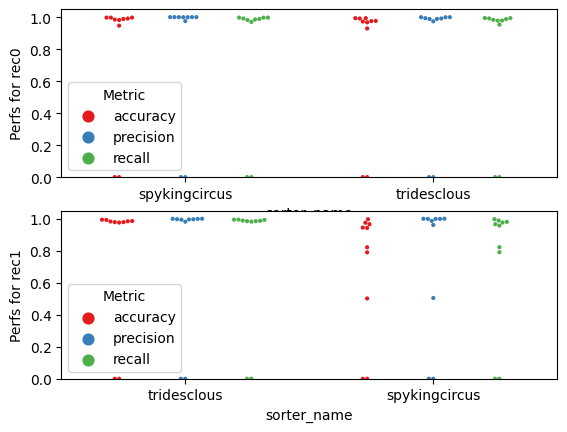

In [29]:
si.plot_gt_study_performences(study)

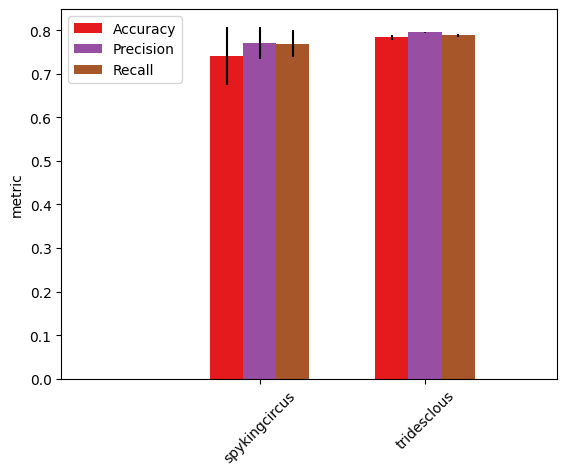

In [30]:
si.plot_gt_study_performences_averages(study)